# Training a neural network on MNIST with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

2022-08-18 17:00:18.647052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 17:00:18.647156: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tim/Dokumente/Projects/jupyterLab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2022-08-18 17:00:27.520835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-18 17:00:27.526494: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-18 17:00:27.526621: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (VirtDebian): /proc/driver/nvidia/version does not exist
2022-08-18 17:00:27.533277: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [4]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

2022-08-18 17:00:53.452612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15752 of 697932
2022-08-18 17:01:03.456031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 34462 of 697932
2022-08-18 17:01:13.452395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 51098 of 697932
2022-08-18 17:01:23.452873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 68724 of 697932
2022-08-18 17:01:33.452400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 86022 of 697932
2022-08-18 17:01:43.454166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 102312 of 697932
2022-08-18 17:01:53.452961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:

<class 'tuple'>
(28, 28, 1)
(128,)


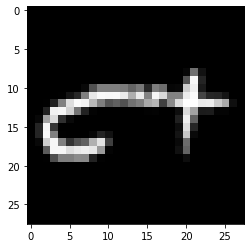

15 F


In [5]:
import matplotlib.pyplot as plt
charList = ['0','1','2','3','4','5','6','7','8','9',
'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']


#print(ds_train.inspect)
#dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for element in ds_train:
    #print(element)
    break
for element in ds_train.as_numpy_iterator():
    print(type(element))
    element1, element2 = element
    print(element1[0].shape)
    print(element2.shape)
    plt.imshow(element1[0], cmap='gray') #Bilder sind gedreht und gespiegelt
    plt.show()
    print(element2[0], charList[element2[0]])
    break


## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(62, "sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    #optimizer=tf.keras.optimizers.Adam(0.001),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_test,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='tfKerasCharsEMNISTSigmoid', save_best_only=True, monitor="val_loss"),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)]
)

Epoch 1/30
5452/5453 [============================>.] - ETA: 0s - loss: 0.7806 - sparse_categorical_accuracy: 0.7672

2022-08-18 17:11:21.772456: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSigmoid/assets


INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSigmoid/assets


5453/5453 [==============================] - 122s 22ms/step - loss: 0.7806 - sparse_categorical_accuracy: 0.7672 - val_loss: 0.5992 - val_sparse_categorical_accuracy: 0.8095
Epoch 2/30
5449/5453 [============================>.] - ETA: 0s - loss: 0.5734 - sparse_categorical_accuracy: 0.8164INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSigmoid/assets


INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSigmoid/assets


5453/5453 [==============================] - 94s 17ms/step - loss: 0.5734 - sparse_categorical_accuracy: 0.8164 - val_loss: 0.5591 - val_sparse_categorical_accuracy: 0.8206
Epoch 3/30
5453/5453 [==============================] - 86s 15ms/step - loss: 0.5497 - sparse_categorical_accuracy: 0.8226 - val_loss: 0.5746 - val_sparse_categorical_accuracy: 0.8201
Epoch 4/30
5453/5453 [==============================] - 93s 17ms/step - loss: 0.5437 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.5667 - val_sparse_categorical_accuracy: 0.8203
Epoch 5/30
5453/5453 [==============================] - 96s 17ms/step - loss: 0.5438 - sparse_categorical_accuracy: 0.8253 - val_loss: 0.5646 - val_sparse_categorical_accuracy: 0.8220
Epoch 6/30
5453/5453 [==============================] - 88s 16ms/step - loss: 0.5488 - sparse_categorical_accuracy: 0.8248 - val_loss: 0.5811 - val_sparse_categorical_accuracy: 0.8168
Epoch 7/30
5453/5453 [==============================] - 85s 15ms/step - loss: 0.5549 - spar

In [7]:
converter = tf.lite.TFLiteConverter.from_saved_model('tfKerasCharsEMNISTSigmoid')
tflite_model = converter.convert()

with open("tfKerasCharsEMNISTSigmoid.tflite", "wb") as fp:
    fp.write(tflite_model)

2022-08-18 17:55:26.548270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-08-18 17:55:26.548336: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-08-18 17:55:26.549246: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: tfKerasCharsEMNISTSigmoid
2022-08-18 17:55:26.550519: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-08-18 17:55:26.550560: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: tfKerasCharsEMNISTSigmoid
2022-08-18 17:55:26.555152: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-08-18 17:55:26.629378: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: tfKerasCharsEMNISTSigmoid
2022-08-18 17:55:26.655962: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 62)                7998      
                                                                 
Total params: 108,478
Trainable params: 108,478
Non-trainable params: 0
_________________________________________________________________
Element1 Shape (28, 28, 1)
Ergebnis Shape (1, 62)
Zeichen unmapped 0 Zeichen mapped 0 Ergebnis 5.089538e-07
Element 0


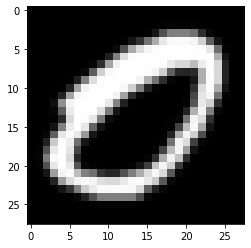

In [8]:
import numpy as np
import tensorflow as tf

charList = ['0','1','2','3','4','5','6','7','8','9',
'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

model = tf.keras.models.load_model('tfKerasCharsEMNISTSigmoid')
model.summary()

for element in ds_train.as_numpy_iterator():
    element1, element2 = element
    ele = np.resize(element1[0],(1,28,28,1))
    erg = model.predict(ele)
    print("Element1 Shape", element1[0].shape)
    print("Ergebnis Shape", erg.shape)
    print("Zeichen unmapped", np.argmax(erg), "Zeichen mapped", charList[np.argmax(erg)], "Ergebnis", erg[0][np.argmax(erg)])
    print("Element", element2[0])
    plt.imshow(element1[0], cmap='gray') #Bilder sind gedreht und gespiegelt
    plt.show()
    break

In [9]:
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('tfKerasCharsEMNISTSigmoid')
model.summary()

data = np.random.randint(0, 255, (1, 28, 28))/255

print(data.shape)
#print(data[1][1])

erg = model.predict(data)
#print(np.argmax(erg))
print(erg)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 62)                7998      
                                                                 
Total params: 108,478
Trainable params: 108,478
Non-trainable params: 0
_________________________________________________________________
(1, 28, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
import numpy as np

interpreter = tf.lite.Interpreter(model_path="tfKerasCharsEMNISTSigmoid.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], data.astype(np.float32))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
